# Degradation example with clearsky workflow


This juypter notebook is intended to illustrate the degradation analysis workflow.  In addition, the notebook demonstrates the effects of changes in the workflow. For a consistent experience, we recommend installing the packages and versions documented in `docs/notebook_requirements.txt`. This can be achieved in your environment by running `pip install -r docs/notebook_requirements.txt` from the base directory. (RdTools must also be separately installed.)

The degradation calculations consist of several steps illustrated here:
<ol start="0">
  <li><b>Import and preliminary calculations</b></li>
  <li><b>Normalize</b> data using a performance metric</li>
  <li><b>Filter</b> data that creates bias</li>
  <li><b>Aggregate data</b></li>
  <li> <b>Analyze</b> aggregated data to estimate the degradation rate</li>
</ol>

After demonstrating these steps using sensor data, a modified version of the workflow is illustrated using modled clear sky irradiance and temperature. The results from the two methods are compared

This notebook works with public data from the the Desert Knowledge Australia Solar Centre. Please download the site data from Site 12, and unzip the csv file in the folder:
./rdtools/docs/

Note this example was run with data downloaded on Sept. 28, 2018. An older version of the data gave different sensor-based results. If you have an older version of the data and are getting different results, please try redownloading the data.

http://dkasolarcentre.com.au/historical-data/download

In [1]:
from datetime import timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pvlib
import rdtools
%matplotlib inline

# This helps dates get plotted properly
pd.plotting.register_matplotlib_converters()

/anaconda2/envs/rdtools_dev/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#Update the style of plots
import matplotlib
matplotlib.rcParams.update({'font.size': 12,
                           'figure.figsize': [4.5, 3],
                           'lines.markeredgewidth': 0,
                           'lines.markersize': 2
                           })

# 0: Import and preliminary calculations


This section prepares the data necesary for an `rdtools` calculation. The first step of the `rdtools` workflow is normaliztion, which requires a time series of energy yield, a time series of cell temperature, and a time series of irradiance, along with some metadata (see Step 1: Normalize)

The following section loads the data, adjusts units where needed, and renames the critical columns. The irradiance sensor data source is transposed to plane-of-array, and the temperature sensor data source is converted into estimated cell temperature.

A common challenge is handling datasets with and without daylight savings time. Make sure to specify a `pytz` timezone that does or does not include daylight savings time as appropriate for your dataset.

<b>The steps of this section may change depending on your data source or the system being considered. Note that nothing in this first section utlizes the `rdtools` library.</b> Transposition of irradiance and modeling of cell temperature are generally outside the scope of `rdtools`. A variety of tools for these calculations are avaialble in [`pvlib`](https://github.com/pvlib/pvlib-python).

/anaconda2/envs/rdtools_dev/lib/python3.6/site-packages/pvlib/irradiance.py:285: RuntimeWarning: invalid value encountered in maximum
  beam = np.maximum(beam, 0)


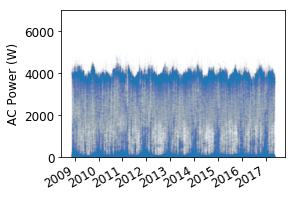

In [3]:
file_name = '84-Site_12-BP-Solar.csv'

df = pd.read_csv(file_name)
try:
    df.columns = [col.decode('utf-8') for col in df.columns]
except AttributeError:
    pass  # Python 3 strings are already unicode literals
df = df.rename(columns = {
    u'12 BP Solar - Active Power (kW)':'power',
    u'12 BP Solar - Wind Speed (m/s)': 'wind',
    u'12 BP Solar - Weather Temperature Celsius (\xb0C)': 'Tamb',
    u'12 BP Solar - Global Horizontal Radiation (W/m\xb2)': 'ghi',
    u'12 BP Solar - Diffuse Horizontal Radiation (W/m\xb2)': 'dhi'
})

# Specify the Metadata
meta = {"latitude": -23.762028,
        "longitude": 133.874886,
        "timezone": 'Australia/North',
        "tempco": -0.005,
        "azimuth": 0,
        "tilt": 20,
        "pdc": 5100.0,
        "temp_model": 'open_rack_cell_polymerback'}

df.index = pd.to_datetime(df.Timestamp)
# TZ is required for irradiance transposition
df.index = df.index.tz_localize(meta['timezone'], ambiguous = 'infer') 

# Explicitly trim the dates so that runs of this example notebook 
# are comparable when the sourec dataset has been downloaded at different times
df = df['2008-11-11':'2017-05-15']

# Chage power from kilowatts to watts
df['power'] = df.power * 1000.0

# There is some missing data, but we can infer the frequency from the first several data points
freq = pd.infer_freq(df.index[:10])

# And then set the frequency of the dataframe
df = rdtools.interpolate(df, freq, pd.to_timedelta('15 minutes'))

# Calculate energy yield in Wh
df['energy'] = rdtools.energy_from_power(df.power, max_timedelta=pd.to_timedelta('15 minutes'))

# Calculate POA irradiance from DHI, GHI inputs
loc = pvlib.location.Location(meta['latitude'], meta['longitude'], tz = meta['timezone'])
sun = loc.get_solarposition(df.index)

# calculate the POA irradiance
sky = pvlib.irradiance.isotropic(meta['tilt'], df.dhi)
df['dni'] = (df.ghi - df.dhi)/np.cos(np.deg2rad(sun.zenith))
beam = pvlib.irradiance.beam_component(meta['tilt'], meta['azimuth'], sun.zenith, sun.azimuth, df.dni)
df['poa'] = beam + sky

# Calculate cell temperature
df_temp = pvlib.pvsystem.sapm_celltemp(df.poa, df.wind, df.Tamb, model = meta['temp_model'])
df['Tcell'] = df_temp.temp_cell

# plot the AC power time series
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(df.index, df.power, 'o', alpha = 0.01)
ax.set_ylim(0,7000)
fig.autofmt_xdate()
ax.set_ylabel('AC Power (W)');

# 1: Normalize

Data normalization is achieved with `rdtools.normalize_with_pvwatts()`. We provide a time sereis of energy, along with keywords used to run a pvwatts model of the system. More information available in the docstring.

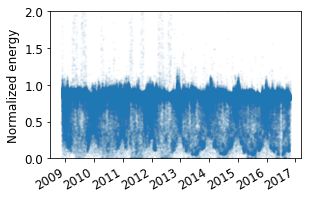

In [4]:
# Specify the keywords for the pvwatts model
pvwatts_kws = {"poa_global" : df.poa,
              "P_ref" : meta['pdc'],
              "T_cell" : df.Tcell,
              "G_ref" : 1000,
              "T_ref": 25,
              "gamma_pdc" : meta['tempco']}

# Calculate the normaliztion, the function also returns the relevant insolation for
# each point in the normalized PV energy timeseries
normalized, insolation = rdtools.normalize_with_pvwatts(df.energy, pvwatts_kws)

df['normalized'] = normalized
df['insolation'] = insolation

# Plot the normalized power time series
fig, ax = plt.subplots()
ax.plot(normalized.index, normalized, 'o', alpha = 0.05)
ax.set_ylim(0,2)
fig.autofmt_xdate()
ax.set_ylabel('Normalized energy');

# 2: Filter

Data filtering is used to exclude data points that represent invalid data, create bias in the analysis, or introduce significant noise.

It can also be useful to remove outages and outliers. Sometimes outages appear as low but non-zero yield. Automatic functions for this are not yet included in `rdtools`. Such filters should be implimented by the analyst if needed.

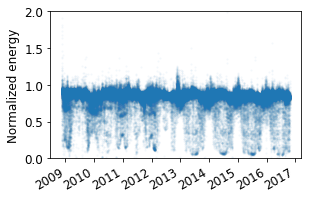

In [5]:
# Calculate a collection of boolean masks that can be used
# to filter the time series
nz_mask = (df['normalized'] > 0)
poa_mask = rdtools.poa_filter(df['poa'])
tcell_mask = rdtools.tcell_filter(df['Tcell'])
clip_mask = rdtools.clip_filter(df['power'])

# filter the time series and keep only the columns needed for the
# remaining steps
filtered = df[nz_mask & poa_mask & tcell_mask & clip_mask]
filtered = filtered[['insolation', 'normalized']]

fig, ax = plt.subplots()
ax.plot(filtered.index, filtered.normalized, 'o', alpha = 0.05)
ax.set_ylim(0,2)
fig.autofmt_xdate()
ax.set_ylabel('Normalized energy');

# 3: Aggregate

Data is aggregated with an irradiance weighted average. This can be useful, for example with daily aggregation, to reduce the impact of high-error data points in the morning and evening.

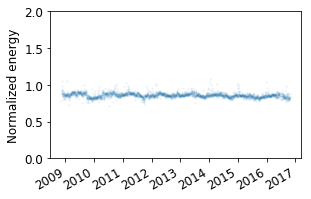

In [6]:
daily = rdtools.aggregation_insol(filtered.normalized, filtered.insolation, frequency = 'D')

fig, ax = plt.subplots()
ax.plot(daily.index, daily, 'o', alpha = 0.1)
ax.set_ylim(0,2)
fig.autofmt_xdate()
ax.set_ylabel('Normalized energy');

# 4: Degradation calculation

Data is then analyzed to estimate the degradation rate representing the PV system behavior. The results are visualized and statistics are reported, including the 68.2% confidence interval, and the P95 exceedence value.

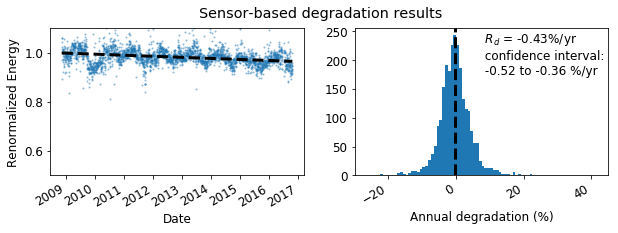

In [7]:
# Calculate the degradation rate using the YoY method
yoy_rd, yoy_ci, yoy_info = rdtools.degradation_year_on_year(daily, confidence_level=68.2)
# Note the default confidence_level of 68.2 is approrpriate if you would like to 
# report a confidence interval analogous to the standard deviation of a normal
# distribution. The size of the confidence interval is adjustable by setting the
# confidence_level variable.

# Visualize the results
start = daily.index[0]
end = daily.index[-1]
years = (end - start).days / 365.0
yoy_values = yoy_info['YoY_values']

x = [start, end]
y = [1, 1 + (yoy_rd * years)/100]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 3))
ax2.hist(yoy_values, label='YOY', bins=len(yoy_values)//40)
ax2.axvline(x=yoy_rd, color='black', linestyle='dashed', linewidth=3)
ax2.set_xlim(-30,45)
ax2.annotate( u' $R_{d}$ = %.2f%%/yr \n confidence interval: \n %.2f to %.2f %%/yr' 
             %(yoy_rd, yoy_ci[0], yoy_ci[1]),  xy=(0.5, 0.7), xycoords='axes fraction',
            bbox=dict(facecolor='white', edgecolor=None, alpha = 0))
ax2.set_xlabel('Annual degradation (%)');

ax1.plot(daily.index, daily/yoy_info['renormalizing_factor'], 'o', alpha = 0.5)
ax1.plot(x, y, 'k--', linewidth=3)
ax1.set_xlabel('Date')
ax1.set_ylabel('Renormalized Energy')
ax1.set_ylim(0.5, 1.1)
fig.autofmt_xdate()

fig.suptitle('Sensor-based degradation results');

In addition to the confidence interval, the year-on-year method yields an exceedence value (e.g. P95), the degradation rate that was exceeded (slower degradation) with a given probability level. The probability level is set via the `exceedence_prob` keyword in `degradation_year_on_year`.

In [8]:
print('The P95 exceedance level is %.2f%%/yr' % yoy_info['exceedance_level'])

The P95 exceedance level is -0.58%/yr


# Clear sky workflow
The clear sky workflow is useful in that it avoids problems due to drift or recalibration of ground-based sensors. We use `pvlib` to model the clear sky irradiance. This is renormalized to align it with ground-based measurements. Finally we use `rdtools.get_clearsky_tamb()` to model the ambient temperature on clear sky days. This modeled ambient temperature is used to model cell temperature with `pvlib`. If high quality amabient temperature data is available, that can be used instead of the modeled ambient; we proceed with the modeled ambient temperature here for illustrative purposes.

In this example, note that we have omitted wind data in the cell temperature calculations for illustrative purposes. Wind data can also be included when the data source is trusted for improved results

**Note that the claculations below rely on some objects from the steps above**

# Clear Sky 0: Preliminary Calculations

In [9]:
# Calculate the clear sky POA irradiance
clearsky = loc.get_clearsky(df.index, solar_position = sun)
cs_sky = pvlib.irradiance.isotropic(meta['tilt'], clearsky.dhi)
cs_beam = pvlib.irradiance.beam_component(meta['tilt'], meta['azimuth'], sun.zenith, sun.azimuth, clearsky.dni)
df['clearsky_poa'] = cs_beam + cs_sky

# Renormalize the clear sky POA irradiance
df['clearsky_poa'] = rdtools.irradiance_rescale(df.poa, df.clearsky_poa, method='iterative')

# Calculate the clearsky temperature
df['clearsky_Tamb'] = rdtools.get_clearsky_tamb(df.index, meta['latitude'], meta['longitude'])
df_clearsky_temp = pvlib.pvsystem.sapm_celltemp(df.clearsky_poa, 0, df.clearsky_Tamb, model = meta['temp_model'])
df['clearsky_Tcell'] = df_clearsky_temp.temp_cell

/anaconda2/envs/rdtools_dev/lib/python3.6/site-packages/pvlib/clearsky.py:126: RuntimeWarning: invalid value encountered in fmax
  ghi = cg1 * dni_extra * cos_zenith * tl / tl * np.fmax(ghi, 0)
/anaconda2/envs/rdtools_dev/lib/python3.6/site-packages/pvlib/clearsky.py:131: RuntimeWarning: invalid value encountered in fmax
  bnci = dni_extra * np.fmax(bnci, 0)


# Clear Sky 1: Normalize
Normalize as in step 1 above, but this time using clearsky modeled irradiance and cell temperature

In [10]:
clearsky_pvwatts_kws = {"poa_global" : df.clearsky_poa,
              "P_ref" : meta['pdc'],
              "T_cell" :df.clearsky_Tcell,
              "G_ref" : 1000,
              "T_ref": 25,
              "gamma_pdc" : meta['tempco']}

clearsky_normalized, clearsky_insolation = rdtools.normalize_with_pvwatts(df.energy, clearsky_pvwatts_kws)

df['clearsky_normalized'] = clearsky_normalized
df['clearsky_insolation'] = clearsky_insolation

# Clear Sky 2: Filter
Filter as in step 2 above, but with the addition of a clear sky index (csi) filter so we consider only points well modeled by the clear sky irradiance model.

In [11]:
# Perform clearsky filter
cs_nz_mask = (df['clearsky_normalized'] > 0)
cs_poa_mask = rdtools.poa_filter(df['clearsky_poa'])
cs_tcell_mask = rdtools.tcell_filter(df['clearsky_Tcell'])

csi_mask = rdtools.csi_filter(df.insolation, df.clearsky_insolation)


clearsky_filtered = df[cs_nz_mask & cs_poa_mask & cs_tcell_mask & clip_mask & csi_mask]
clearsky_filtered = clearsky_filtered[['clearsky_insolation', 'clearsky_normalized']]

# Clear Sky 3: Aggregate
Aggregate the clear sky version of of the filtered data 

In [12]:
clearsky_daily = rdtools.aggregation_insol(clearsky_filtered.clearsky_normalized, clearsky_filtered.clearsky_insolation)

# Clear Sky 4: Degradation Calculation
Estimate the degradation rate and compare to the results obtained with sensors. In this case, we see that irradiance sensor drift may have biased the sensor-based results, a problem that is corrected by the clear sky approach.

The P95 exceedance level with the clear sky analysis is -0.39%/yr


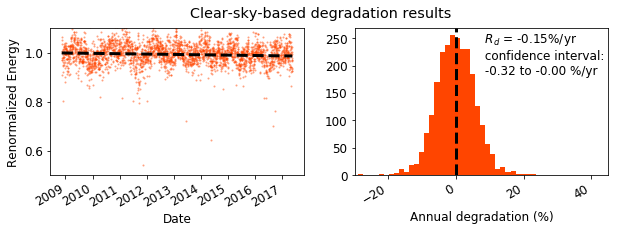

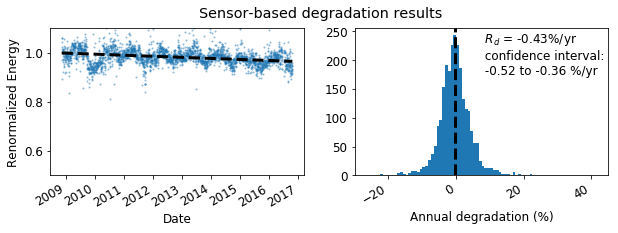

In [13]:
# Calculate the degradation rate using the YoY method
cs_yoy_rd, cs_yoy_ci, cs_yoy_info = rdtools.degradation_year_on_year(clearsky_daily, confidence_level=68.2)
# Note the default confidence_level of 68.2 is approrpriate if you would like to 
# report a confidence interval analogous to the standard deviation of a normal
# distribution. The size of the confidence interval is adjustable by setting the
# confidence_level variable.

# Visualize the results
cs_start = clearsky_daily.index[0]
cs_end = clearsky_daily.index[-1]
cs_years = (cs_end - cs_start).days / 365.0
cs_yoy_values = cs_yoy_info['YoY_values']

cs_x = [cs_start, cs_end]
cs_y = [1, 1 + (cs_yoy_rd * cs_years)/100]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 3))
ax2.hist(cs_yoy_values, label='YOY', bins=len(cs_yoy_values)//40, color = 'orangered')
ax2.axvline(x=cs_yoy_rd, color='black', linestyle='dashed', linewidth=3)
ax2.set_xlim(-30,45)
ax2.annotate( u' $R_{d}$ = %.2f%%/yr \n confidence interval: \n %.2f to %.2f %%/yr' 
             %(cs_yoy_rd, cs_yoy_ci[0], cs_yoy_ci[1]),  xy=(0.5, 0.7), xycoords='axes fraction',
            bbox=dict(facecolor='white', edgecolor=None, alpha = 0))
ax2.set_xlabel('Annual degradation (%)');

ax1.plot(clearsky_daily.index, clearsky_daily/cs_yoy_info['renormalizing_factor'], 'o', color = 'orangered', alpha = 0.5)
ax1.plot(cs_x, cs_y, 'k--', linewidth=3)
ax1.set_xlabel('Date')
ax1.set_ylabel('Renormalized Energy')
ax1.set_ylim(0.5, 1.1)
fig.autofmt_xdate()

fig.suptitle('Clear-sky-based degradation results');



# repeat the plots from above
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 3))
ax2.hist(yoy_values, label='YOY', bins=len(yoy_values)//40)
ax2.axvline(x=yoy_rd, color='black', linestyle='dashed', linewidth=3)
ax2.set_xlim(-30,45)
ax2.annotate( u' $R_{d}$ = %.2f%%/yr \n confidence interval: \n %.2f to %.2f %%/yr' 
             %(yoy_rd, yoy_ci[0], yoy_ci[1]),  xy=(0.5, 0.7), xycoords='axes fraction',
            bbox=dict(facecolor='white', edgecolor=None, alpha = 0))
ax2.set_xlabel('Annual degradation (%)');

ax1.plot(daily.index, daily/yoy_info['renormalizing_factor'], 'o', alpha = 0.5)
ax1.plot(x, y, 'k--', linewidth=3)
ax1.set_xlabel('Date')
ax1.set_ylabel('Renormalized Energy')
ax1.set_ylim(0.5, 1.1)
fig.autofmt_xdate()

fig.suptitle('Sensor-based degradation results');

print('The P95 exceedance level with the clear sky analysis is %.2f%%/yr' % cs_yoy_info['exceedance_level'])